In [1]:
import os
import sys
sys.path.append(os.path.abspath("../"))

from matplotlib import pyplot as plt
import numpy as np
import tensorflow as tf

import math
from src.utils import reload_script
import warnings

from models_src.Support import LRCallback
from models_src.UNet_model import UNet
from models_src.Metrics import WeightedF12D, LossBasedMetric
import models_src.VecModels as vcm

from models_src.VecDataset import MultishapeMapGenerator, DatasetGenerator, blur_img, op_sample_points_vecs
from models_src.fft_lib import xy_coords, decode1Dcoords, encode1Dcoords
from models_src.Trainer import TrainingProcessor2
from Fourier.datasets.generator_cfg import generator_cfg
%matplotlib inline

from models_src.Attn_variations import SqueezeImg, UnSqueezeImg

from models_src.DETR import FFN, MHA

from models_src.Mask_RCNN import CombinedMetricsModel

print(tf.config.list_physical_devices('GPU'))

2024-08-28 12:44:21.567208: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-28 12:44:21.587312: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-28 12:44:21.608196: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-28 12:44:21.613562: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-28 12:44:21.629216: I tensorflow/core/platform/cpu_feature_guar

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


I0000 00:00:1724841868.784943   89803 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:7c:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724841868.836462   89803 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:7c:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724841868.836557   89803 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:7c:00.0/numa_node
Your kernel may have been built without NUMA support.


In [43]:
reload_script('models_src.VecDataset')

In [2]:
import mlflow

mlflow.set_tracking_uri("http://localhost:5000")
mlflow.set_experiment("vec_detection")
mlflow.tensorflow.autolog(log_datasets=False, log_models=True, disable=True, checkpoint=False)

In [3]:
class cfg:
    train_batch_size = 32
    val_batch_size = 64
    test_batch_size = 8
    sample_points = 20
    #ds_path = './datasets/pixel_similarity'
    ds_path = './datasets/intense_lines'

msmg = MultishapeMapGenerator(['img', 'angle_label', 'center_vec_label', 'line_label', 'shape_label', 'thickness_label', 'pattern_masks', 'shape_masks', 'vecs_masks', 'bbox_masks', 'vecs', 'bboxes', 'vecs_mask', 'bbox_mask', 'shape_thickness'],
                              generator_cfg.size, 
                              **generator_cfg.drawing_args, 
                              patterns_prob=generator_cfg.patterns_prob, 
                              line_args=generator_cfg.line_args, 
                              shape_args=generator_cfg.shape_args, 
                              line_filled_args=generator_cfg.line_filled_args, 
                              polyline_args=generator_cfg.polyline_args, 
                              linear_shapes_args=generator_cfg.linear_shapes_args, 
                              spreaded_shapes_args=generator_cfg.spreaded_shapes_args
                              )

dg = DatasetGenerator(msmg, 
                      ds_path=cfg.ds_path, 
                      fold_size=512*4, 
                      parallel_calls=4, 
                      padded_batch=True, 
                      output_filter=['img','vecs_masks', 'bbox_masks', 'vecs', 'bboxes', 'vecs_mask', 'bbox_mask'],
                      preprocess_funcs=[(blur_img, {'blur_ratio_range': (0.1, 0.6), 'kernel_size': 3, 'color_rand_range': 0.1}, True),
                                        (op_sample_points_vecs, {'n': cfg.sample_points}, True)]
                      )

ds, train_steps = dg.dataset(from_saved=True, batch_size=cfg.train_batch_size, validation=False, val_idxs=[0], shuffle_buffer_size=128)
val_ds, val_steps = dg.dataset(from_saved=True, batch_size=cfg.val_batch_size, validation=True, val_idxs=[0])
test_ds, test_steps = dg.dataset(from_saved=True, batch_size=cfg.test_batch_size, validation=True, val_idxs=[0])

ds_iter = iter(ds)
val_iter = iter(val_ds)
test_iter = iter(test_ds)

I0000 00:00:1724841868.908982   89803 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:7c:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724841868.909153   89803 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:7c:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724841868.909193   89803 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:7c:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724841869.120107   89803 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:7c:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1724841869.120205   89803 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:7c:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-28

In [4]:
def radial_enc_vec_detection_model_generator(
        enc_type,
        num_heads,
        embs_dim,
        color_embs_dim,
        size,
        embs_mid_layers,
        dropout,
        activation,
        out_mid_layers,
        attns_num,
        pos_enc_matmul,
        queries_self_attn,
        queries_pos_enc_values,
        source_query_cross_attn,
        sample_queries_num,
        angle_based_preds,
        backbone_args,
        backbone_weights_path,
        backbone_generator,
        backbone_last_layer,
        backbone_init_layer,
        backbone_trainable,
        name='RadVecDet'
):
    
    backbone_model = backbone_generator(**backbone_args)
    if backbone_weights_path is not None:
        backbone_model.load_weights(f'./{backbone_weights_path}.weights.h5')

    backbone_model.trainable = backbone_trainable

    img_inputs = backbone_model.input
    memory = backbone_model.get_layer(backbone_last_layer).output
    normed_img = backbone_model.get_layer(backbone_init_layer).output

    if len(memory.shape)==3:
        memory = UnSqueezeImg(name='Initial-Memory-Unsqueeze')(memory)

    sample_inputs = tf.keras.layers.Input((cfg.sample_points,2), name='sample_points')
    split_inputs = tf.keras.layers.Input((cfg.sample_points,), name='class_split')

    enc_func = vcm.FrequencyRadialEncoding if enc_type!='separate' else vcm.SeparateRadialEncoding
    self_enc_func = vcm.SampleFrequencyRadialEncoding if enc_type!='separate' else vcm.SampleSeparateRadialEncoding
    enc_label = 'Freq' if enc_type!='separate' else 'Sep'

    pos_enc = enc_func(emb_dim=embs_dim//num_heads, height=size, name=f'{enc_label}RadialEncoding')(sample_inputs)
    if queries_self_attn:
        self_pos_enc = self_enc_func(emb_dim=embs_dim//num_heads, height=size, name=f'Self{enc_label}RadialEncoding')(sample_inputs, sample_inputs)

    features, sample_features, pos_enc = vcm.SampleRadialSearchFeaturesExtraction(embs_dim=embs_dim, 
                                                                            color_embs_dim=color_embs_dim, 
                                                                            mid_layers=embs_mid_layers,
                                                                            activation=activation,
                                                                            dropout=dropout,
                                                                            batch_dims=1,
                                                                            name='vdSRSFE')(sample_inputs, memory, normed_img, pos_enc)

    print(pos_enc.shape, features.shape, sample_features.shape)

    value_pos_enc = not pos_enc_matmul

    for i in range(attns_num):


        x, scores = vcm.DetectionMHA(key_pos_enc=(i!=0), pos_enc_matmul=pos_enc_matmul, value_pos_enc=value_pos_enc, output_dim=embs_dim, value_dim=embs_dim, key_dim=embs_dim, num_heads=num_heads, name=f'vdMHA_{i+1}')(features, sample_features, features, pos_enc)
        #print(x.shape)
        sample_features = vcm.AddNorm(norm_axis=-1, name=f'vdPostMHA-AddNorm_{i+1}')([sample_features, x])

        if queries_self_attn:
            ### sample self-attn
            V = self_pos_enc if queries_pos_enc_values else tf.keras.layers.Permute([2,1,3], name=f'PreSelfMHA-Permute_{i+1}')(x)     
            x, _ = vcm.DetectionMHA(key_pos_enc=True, value_pos_enc=False, output_dim=embs_dim, value_dim=embs_dim, key_dim=embs_dim, num_heads=num_heads, name=f'SelfMHA_{i+1}')(V, sample_features, V, self_pos_enc)
            sample_features = vcm.AddNorm(norm_axis=-1, name=f'PostSelfMHA-AddNorm_{i+1}')([sample_features, x])

        if source_query_cross_attn & (i<attns_num-1):
            Q_pos_enc = tf.keras.layers.Permute([2,1,3], name=f'PreCrossMHA-PosEnc-Permute_{i+1}')(pos_enc)
            V = tf.keras.layers.Permute([2,1,3], name=f'PreCrossMHA-Sample-Permute_{i+1}')(sample_features)
            Q = tf.keras.layers.Permute([2,1,3], name=f'PreCrossMHA-Features-Permute_{i+1}')(features)
            x, _ = vcm.ExpandedQueriesMHA(output_dim=embs_dim, value_dim=embs_dim, key_dim=embs_dim, num_heads=num_heads, name=f'CrossMHA_{i+1}')(V, Q, V, Q_pos_enc)
            x = tf.keras.layers.Permute([2,1,3], name=f'PreCrossMHA-Features-UnPermute_{i+1}')(x)
            features = vcm.AddNorm(norm_axis=-1, name=f'PostCrossMHA-AddNorm_{i+1}')([features, x])

        if sample_queries_num is not None:
            query_points = vcm.QuerySamplingLayer(queries_num=sample_queries_num, mid_layers=2, mid_units=embs_dim, activation='relu', dropout=0.0, name=f'Query-Sample_{i+1}')([sample_features, sample_inputs])
            query_pos_enc = self_enc_func(emb_dim=embs_dim//num_heads, height=size, expand_b=False, name=f'Query{enc_label}RadialEncoding_{i+1}')(sample_inputs, query_points)
            query_samples = vcm.SampleQueryExtractionLayer(cut_off=1, gamma=2, name=f'Query-Features_{i+1}')([features, query_points])
            sample_features = vcm.SampleQueryMessagePassing(mid_layers=3, mid_units=embs_dim*2, activation='relu', dropout=0.0, name=f'Query-Message_{i+1}')(sample_features, query_samples, query_pos_enc)


        x = FFN(mid_layers=out_mid_layers, mid_units=embs_dim*2, output_units=embs_dim, dropout=dropout, activation=activation, name=f'vdDecoder-FFN_{i+1}')(sample_features)
        sample_features = vcm.AddNorm(norm_axis=-1, name=f'vdPostFFN-AddNorm_{i+1}')([sample_features, x])
        
    vecs, class_preds = vcm.SampleRadialSearchHead(num_samples=cfg.sample_points, ffn_mid_layers=out_mid_layers, mid_units=embs_dim*2, activation=activation, dropout=0.0, angle_pred=angle_based_preds, name='SRShead')(sample_features, sample_inputs, split_inputs)
    
    vecs = tf.keras.layers.Identity(name='vecs')(vecs)
    class_preds = tf.keras.layers.Identity(name='class')(class_preds)

    model = tf.keras.Model(inputs={'img': img_inputs, 'sample_points': sample_inputs, 'class_split': split_inputs}, 
                           outputs={'vecs': vecs, 'class': class_preds}, 
                           name=name)
    
    return model

# Training

In [5]:
'''backbone_args = {
    'input_shape': (32,32,3),
    'init_filters_power': 6,
    'levels': 3,
    'level_convs': 4,
    'init_dropout': 0.0,
    'dropout': 0.3,
    'batch_normalization': True,
    'name': 'PxFeaturesUnet'
}


model_args = {
    'enc_type': 'frequency',
    'num_heads': 2,
    'embs_dim': 128,
    'color_embs_dim': 16,
    'size': 32,
    'embs_mid_layers': 2,
    'dropout': 0.0,
    'activation': 'relu',
    'out_mid_layers': 2,
    'attns_num': 3,
    'pos_enc_matmul': False,
    'queries_self_attn': False,
    'queries_pos_enc_values': False,
    'source_query_cross_attn': False,
    'sample_queries_num': None,
    'angle_based_preds': False,
    'backbone_args': backbone_args,
    'backbone_generator': vcm.pixel_features_unet,
    'backbone_weights_path': './final_state/PxFeaturesUnet/e45_ps',
    'backbone_trainable': False,
    'backbone_last_layer': 'Up-Conv_2',
    'backbone_init_layer': 'Batch-Normalization',
}'''

backbone_args = {
    'enc_type': 'frequency',
    'num_heads': 1,
    'embs_dim': 64,
    'color_embs_dim': 64,
    'size': 32,
    'embs_mid_layers': 2,
    'dropout': 0.0,
    'activation': 'relu',
    'out_mid_layers': 2,
    'attns_num': 3,
    'concat_memory': False,
    'progressive': True,
    'backbone_args': None,
    'backbone_generator': None,
    'backbone_weights_path': None,
    'backbone_trainable': None,
    'backbone_last_layer': None,
    'backbone_init_layer': None,
}


model_args = {
    'enc_type': 'frequency',
    'num_heads': 2,
    'embs_dim': 128,
    'color_embs_dim': 16,
    'size': 32,
    'embs_mid_layers': 2,
    'dropout': 0.0,
    'activation': 'relu',
    'out_mid_layers': 2,
    'attns_num': 3,
    'pos_enc_matmul': False,
    'queries_self_attn': False,
    'queries_pos_enc_values': False,
    'source_query_cross_attn': False,
    'sample_queries_num': None,
    'angle_based_preds': False,
    'backbone_args': backbone_args,
    'backbone_generator': vcm.radial_enc_pixel_features_model_generator,
    'backbone_weights_path': './final_state/PxFeaturesRadEnc/e60_heavy',
    'backbone_trainable': False,
    'backbone_last_layer': 'PostFFN-AddNorm_3',
    'backbone_init_layer': 'Batch-Normalization',
}

compile_args = {
    'optimizer': tf.keras.optimizers.Adam(1e-3),
    'loss': {
        'vecs': vcm.MixedBBoxVecLoss(name='VecLoss', gamma=1, reduction='sum_over_batch_size'),
        'class': tf.keras.losses.BinaryCrossentropy(name='ClassLoss', reduction='sum_over_batch_size', axis=-1)
    },
    'loss_weights': {
        'vecs': 0.7,
        'class': 0.3
    }
}

model_generator = radial_enc_vec_detection_model_generator

In [6]:
trainer = TrainingProcessor2(cfg, mlflow_instance=mlflow)
trainer.load_dataset(ds, train_steps, val_ds, val_steps)
trainer.load_model_generator(model_generator)
trainer.compile_model(
    model_args = model_args,
    print_summary = True,
    summary_kwargs = {'expand_nested': False, 'line_length': 100},
    **compile_args
)

(1, 1024, 1024, 64) (None, 1024, 64)


/home/fzzyfoxx/.local/lib/python3.10/site-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'MHA_1', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/home/fzzyfoxx/.local/lib/python3.10/site-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'MHA_2', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/home/fzzyfoxx/.local/lib/python3.10/site-packages/keras/src/layers/layer.py:372: UserWarning: `build()` was called on layer 'MHA_3', however the 

(None, 20, 1024, 64) (None, 1, 1024, 128) (None, 20, 1, 128)


/home/fzzyfoxx/.local/lib/python3.10/site-packages/keras/src/models/functional.py:106: UserWarning: When providing `inputs` as a dict, all keys in the dict must match the names of the corresponding tensors. Received key 'img' mapping to value <KerasTensor shape=(None, 32, 32, 3), dtype=float32, sparse=None, name=keras_tensor> which has name 'keras_tensor'. Change the tensor name to 'img' (via `Input(..., name='img')`)
  warnings.warn(


Model: "RadVecDet"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                ┃ Output Shape            ┃        Param # ┃ Connected to            ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)    │ (None, 32, 32, 3)       │              0 │ -                       │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ Batch-Normalization         │ (None, 32, 32, 3)       │             12 │ input_layer[0][0]       │
│ (BatchNormalization)        │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ RSFE                        │ [(None, 1024, 64), (1,  │         25,280 │ Batch-Normalization[0]… │
│ (RadialSearchFeaturesExtra… │ 1024, 1024, 64)]        │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ MHA_1 (SelfRadialMHA)       │ [(None, 1024, 64),      │         12,480 │ RSFE[0][1], RSFE[0][0], │
│                             │ (None, 1, 1024, 1024)]  │                │ RSFE[0][0]              │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ Decoder-FFN_1 (FFN)         │ (None, 1024, 64)        │         33,088 │ MHA_1[0][0]             │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ Progressive-SkipCon-FFN_2   │ (None, 1024, 128)       │         41,344 │ Decoder-FFN_1[0][0]     │
│ (FFN)                       │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ MHA_2 (SelfRadialMHA)       │ [(None, 1024, 128),     │         33,152 │ RSFE[0][1],             │
│                             │ (None, 2, 1024, 1024)]  │                │ Decoder-FFN_1[0][0],    │
│                             │                         │                │ Decoder-FFN_1[0][0]     │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ PostMHA-AddNorm_2 (AddNorm) │ (None, 1024, 128)       │            256 │ Progressive-SkipCon-FF… │
│                             │                         │                │ MHA_2[0][0]             │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ Decoder-FFN_2 (FFN)         │ (None, 1024, 128)       │        131,712 │ PostMHA-AddNorm_2[0][0] │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ PostFFN-AddNorm_2 (AddNorm) │ (None, 1024, 128)       │            256 │ PostMHA-AddNorm_2[0][0… │
│                             │                         │                │ Decoder-FFN_2[0][0]     │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ Progressive-SkipCon-FFN_3   │ (None, 1024, 256)       │        164,608 │ PostFFN-AddNorm_2[0][0] │
│ (FFN)                       │                         │                │                         │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ MHA_3 (SelfRadialMHA)       │ [(None, 1024, 256),     │        131,840 │ RSFE[0][1],             │
│                             │ (None, 4, 1024, 1024)]  │                │ PostFFN-AddNorm_2[0][0… │
│                             │                         │                │ PostFFN-AddNorm_2[0][0] │
├─────────────────────────────┼─────────────────────────┼────────────────┼─────────────────────────┤
│ PostMHA-AddNorm_3 (AddNorm) │ (None, 1024, 256)       │            512 │ Progressive-SkipCon-FF… │
│                             │                         │    

 Total params: 1,980,467 (7.55 MB)

 Trainable params: 879,847 (3.36 MB)

 Non-trainable params: 1,100,620 (4.20 MB)

None


In [14]:
trainer.train_model(
    epochs = 40,
    callbacks = [LRCallback(warmup_lr=1e-5, warmup_epochs=1, decay_ratio=0.93)],
    log = True,
    export_final_state = False,
    export_model = False
)

MLflow run: bedecked-cow-701


Epoch 21/60
512/512 ━━━━━━━━━━━━━━━━━━━━ 22s 42ms/step - loss: 1.9804 - val_loss: 1.8730 - learning_rate: 5.6061e-04
Epoch 22/60
512/512 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - loss: 1.8139 - val_loss: 1.8639 - learning_rate: 5.4379e-04
Epoch 23/60
512/512 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - loss: 1.7727 - val_loss: 1.8092 - learning_rate: 5.2748e-04
Epoch 24/60
512/512 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - loss: 1.7677 - val_loss: 1.8017 - learning_rate: 5.1166e-04
Epoch 25/60
512/512 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - loss: 1.8393 - val_loss: 1.7370 - learning_rate: 4.9631e-04
Epoch 26/60
512/512 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - loss: 1.7703 - val_loss: 1.9268 - learning_rate: 4.8142e-04
Epoch 27/60
512/512 ━━━━━━━━━━━━━━━━━━━━ 22s 42ms/step - loss: 1.8165 - val_loss: 1.7681 - learning_rate: 4.6697e-04
Epoch 28/60
512/512 ━━━━━━━━━━━━━━━━━━━━ 22s 42ms/step - loss: 1.7177 - val_loss: 1.7844 - learning_rate: 4.5297e-04
Epoch 29/60
512/512 ━━━━━━━━━━━━━━━━━━━━ 22s 42ms/step - loss: 1

2024/08/28 13:10:42 INFO mlflow.tracking._tracking_service.client: 🏃 View run bedecked-cow-701 at: http://localhost:5000/#/experiments/408468005247886296/runs/750502d98cea4d91887b2b9f44f8cf8e.
2024/08/28 13:10:42 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/408468005247886296.


In [18]:
tf.config.experimental.get_memory_info('GPU:0')['peak']*1e-6

3068.0453119999997

In [26]:
trainer.save_temp_weights('./final_state', filename='e60_radial_il_sfmx', use_model_name=True)

In [16]:
trainer.load_temp_weights('final_state/RadVecDet/e40_radial_il', skip_mismatch=False)

/home/fzzyfoxx/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 158 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [23]:
mlflow.end_run(status="KILLED")

## Metric Validation

In [15]:
vec_mixed_metric = LossBasedMetric(vcm.MixedBBoxVecLoss(name='VecMixLoss', gamma=1, reduction='none'))
vec_metric = LossBasedMetric(vcm.VecLoss(name='VecLoss', gamma=1, reduction='none'))
bbox_metric = LossBasedMetric(vcm.BBoxVecLoss(name='BBoxLoss', gamma=1, reduction='none'))
class_metric = LossBasedMetric(tf.keras.losses.BinaryCrossentropy(name='ClassLoss', reduction='none', axis=-1))

@tf.function(input_signature=[tf.TensorSpec(shape=(cfg.test_batch_size,32,32,3), dtype=tf.float32), 
                              tf.TensorSpec(shape=(cfg.test_batch_size,cfg.sample_points,2), dtype=tf.int32),
                              tf.TensorSpec(shape=(cfg.test_batch_size,cfg.sample_points), dtype=tf.float32),
                              tf.TensorSpec(shape=(cfg.test_batch_size,cfg.sample_points,4,2), dtype=tf.float32),
                              tf.TensorSpec(shape=(cfg.test_batch_size,cfg.sample_points,3), dtype=tf.float32),
                              tf.TensorSpec(shape=(cfg.test_batch_size,cfg.sample_points), dtype=tf.float32),
                              tf.TensorSpec(shape=(), dtype=tf.int32),
                              ], 
                              jit_compile=True, autograph=False)
def tf_eval(img, sample_points, class_split, vecs_label, class_label, class_weights, n):
    vecs_pred, class_pred = trainer.model({'img': img, 'sample_points': sample_points, 'class_split': class_split}, training=False).values()
    vec_mixed_metric.update_state(vecs_label, vecs_pred, class_weights)
    class_metric.update_state(class_label, class_pred, class_weights)

    components_mask = tf.where(class_weights>0, 1.0, 0.0)
    B = tf.shape(img)[0]
    vecs_mask = class_split*components_mask
    vecs_num = tf.reduce_sum(vecs_mask, axis=None, keepdims=True)
    vecs_weights = vecs_mask*tf.math.divide_no_nan(tf.cast(n*B, tf.float32), vecs_num)

    bbox_mask = (1-class_split)*components_mask
    bbox_num = tf.reduce_sum(bbox_mask, axis=None, keepdims=True)
    bbox_weights = bbox_mask*tf.math.divide_no_nan(tf.cast(n*B, tf.float32), bbox_num)

    vecs_pred, bbox_pred = tf.split(vecs_pred, 2, axis=-2)
    vecs_label, bbox_label = tf.split(vecs_label, 2, axis=-2)

    vec_metric.update_state(vecs_label, vecs_pred, vecs_weights)
    bbox_metric.update_state(bbox_label, bbox_pred, bbox_weights)

In [16]:
with tf.device('/GPU:0'):
    vec_mixed_metric.reset_state()
    class_metric.reset_state()
    pb = tf.keras.utils.Progbar(test_steps, stateful_metrics=['VecMixLoss','VecLoss', 'BBoxLoss', 'ClassLoss'])

    for i in range(test_steps):
        features, labels, labels_weights = next(test_iter)
        img, sample_points, class_split = features.values()
        vecs_labels, components_class = labels.values()
        vecs_weights, class_weights = labels_weights.values()
        tf_eval(img, sample_points, class_split, vecs_labels, components_class, vecs_weights, cfg.sample_points)
        pb.update(i+1, values=[('VecMixLoss', vec_mixed_metric.result().numpy()),
                               ('VecLoss', vec_metric.result().numpy()),
                               ('BBoxLoss', bbox_metric.result().numpy()),
                               ('ClassLoss', class_metric.result().numpy())])

256/256 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step - VecMixLoss: 2.0758 - VecLoss: 2.2553 - BBoxLoss: 1.3328 - ClassLoss: 0.2350


In [17]:
run_id = mlflow.search_runs(order_by=['start_time DESC']).iloc[0].run_id
with mlflow.start_run(run_id=run_id):
    for metric_name, metric_value in zip(['VecMixedLoss', 'VecLoss', 'BBoxLoss', 'ClassLoss'], [m.result().numpy() for m in [vec_mixed_metric, vec_metric, bbox_metric, class_metric]]):
        mlflow.log_metric(metric_name, metric_value)

2024/08/28 13:11:13 INFO mlflow.tracking._tracking_service.client: 🏃 View run bedecked-cow-701 at: http://localhost:5000/#/experiments/408468005247886296/runs/750502d98cea4d91887b2b9f44f8cf8e.
2024/08/28 13:11:13 INFO mlflow.tracking._tracking_service.client: 🧪 View experiment at: http://localhost:5000/#/experiments/408468005247886296.


# Test

In [10]:
features, labels, labels_weights = next(test_iter)
img, sample_points, class_split = features.values()
vecs_labels, components_class = labels.values()
vecs_weights, class_weights = labels_weights['vecs'], labels_weights['class']


print('img', img.shape, img.dtype)
print('sample_points', sample_points.shape, sample_points.dtype)
print('class_split', class_split.shape, class_split.dtype)
print('vec_labels', vecs_labels.shape, vecs_labels.dtype)
print('components_class', components_class.shape, components_class.dtype)
print('vecs_weights', vecs_weights.shape, vecs_weights.dtype)
print('class_weights', class_weights.shape, class_weights.dtype)

img (8, 32, 32, 3) <dtype: 'float32'>
sample_points (8, 20, 2) <dtype: 'int32'>
class_split (8, 20) <dtype: 'float32'>
vec_labels (8, 20, 4, 2) <dtype: 'float32'>
components_class (8, 20, 3) <dtype: 'float32'>
vecs_weights (8, 20) <dtype: 'float32'>
class_weights (8, 20) <dtype: 'float32'>


In [19]:
def gather_sorted_components(x, components_class):
    return tf.concat([tf.gather(x, tf.where(components_class==2)[...,0], axis=0),
                                 tf.gather(x, tf.where(components_class==1)[...,0], axis=0)], axis=0)

def bold_argmax_print(x, round_digits=2):
    i_max = np.argmax(x)
    output = [str(round(elem,round_digits)) if i!=i_max else r'$\bf{x}$'.format(x=str(round(elem,round_digits))) for i,elem in enumerate(x)]
    output = ', '.join(output)

    return output

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


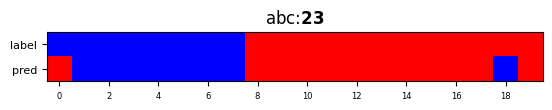

In [36]:
label_colors = tf.one_hot(components_class, 3)
pred_colors = tf.one_hot(tf.argmax(pred_class, axis=-1), 3)

stacked_colors = tf.stack([label_colors, pred_colors], axis=-3)*255

plt.imshow(stacked_colors[0])
plt.yticks([0,1],['label', 'pred'], fontsize=8)
plt.xticks(np.arange(0, cfg.sample_points, 2), np.arange(0, cfg.sample_points, 2), fontsize=6)
plt.title(r'abc:$\bf{x}$'.format(x=23))
plt.show()

In [38]:
print('\n abc ')


 abc 


img (8, 32, 32, 3) <dtype: 'float32'>
sample_points (8, 20, 2) <dtype: 'int32'>
class_split (8, 20) <dtype: 'float32'>
vec_labels (8, 20, 4, 2) <dtype: 'float32'>
components_class (8, 20, 3) <dtype: 'float32'>
vecs_weights (8, 20) <dtype: 'float32'>
class_weights (8, 20) <dtype: 'float32'>
pred_vecs (8, 20, 4, 2) <dtype: 'float32'>
pred_class (8, 20, 3) <dtype: 'float32'>

 background: RED, bbox: GREEN, line: BLUE 



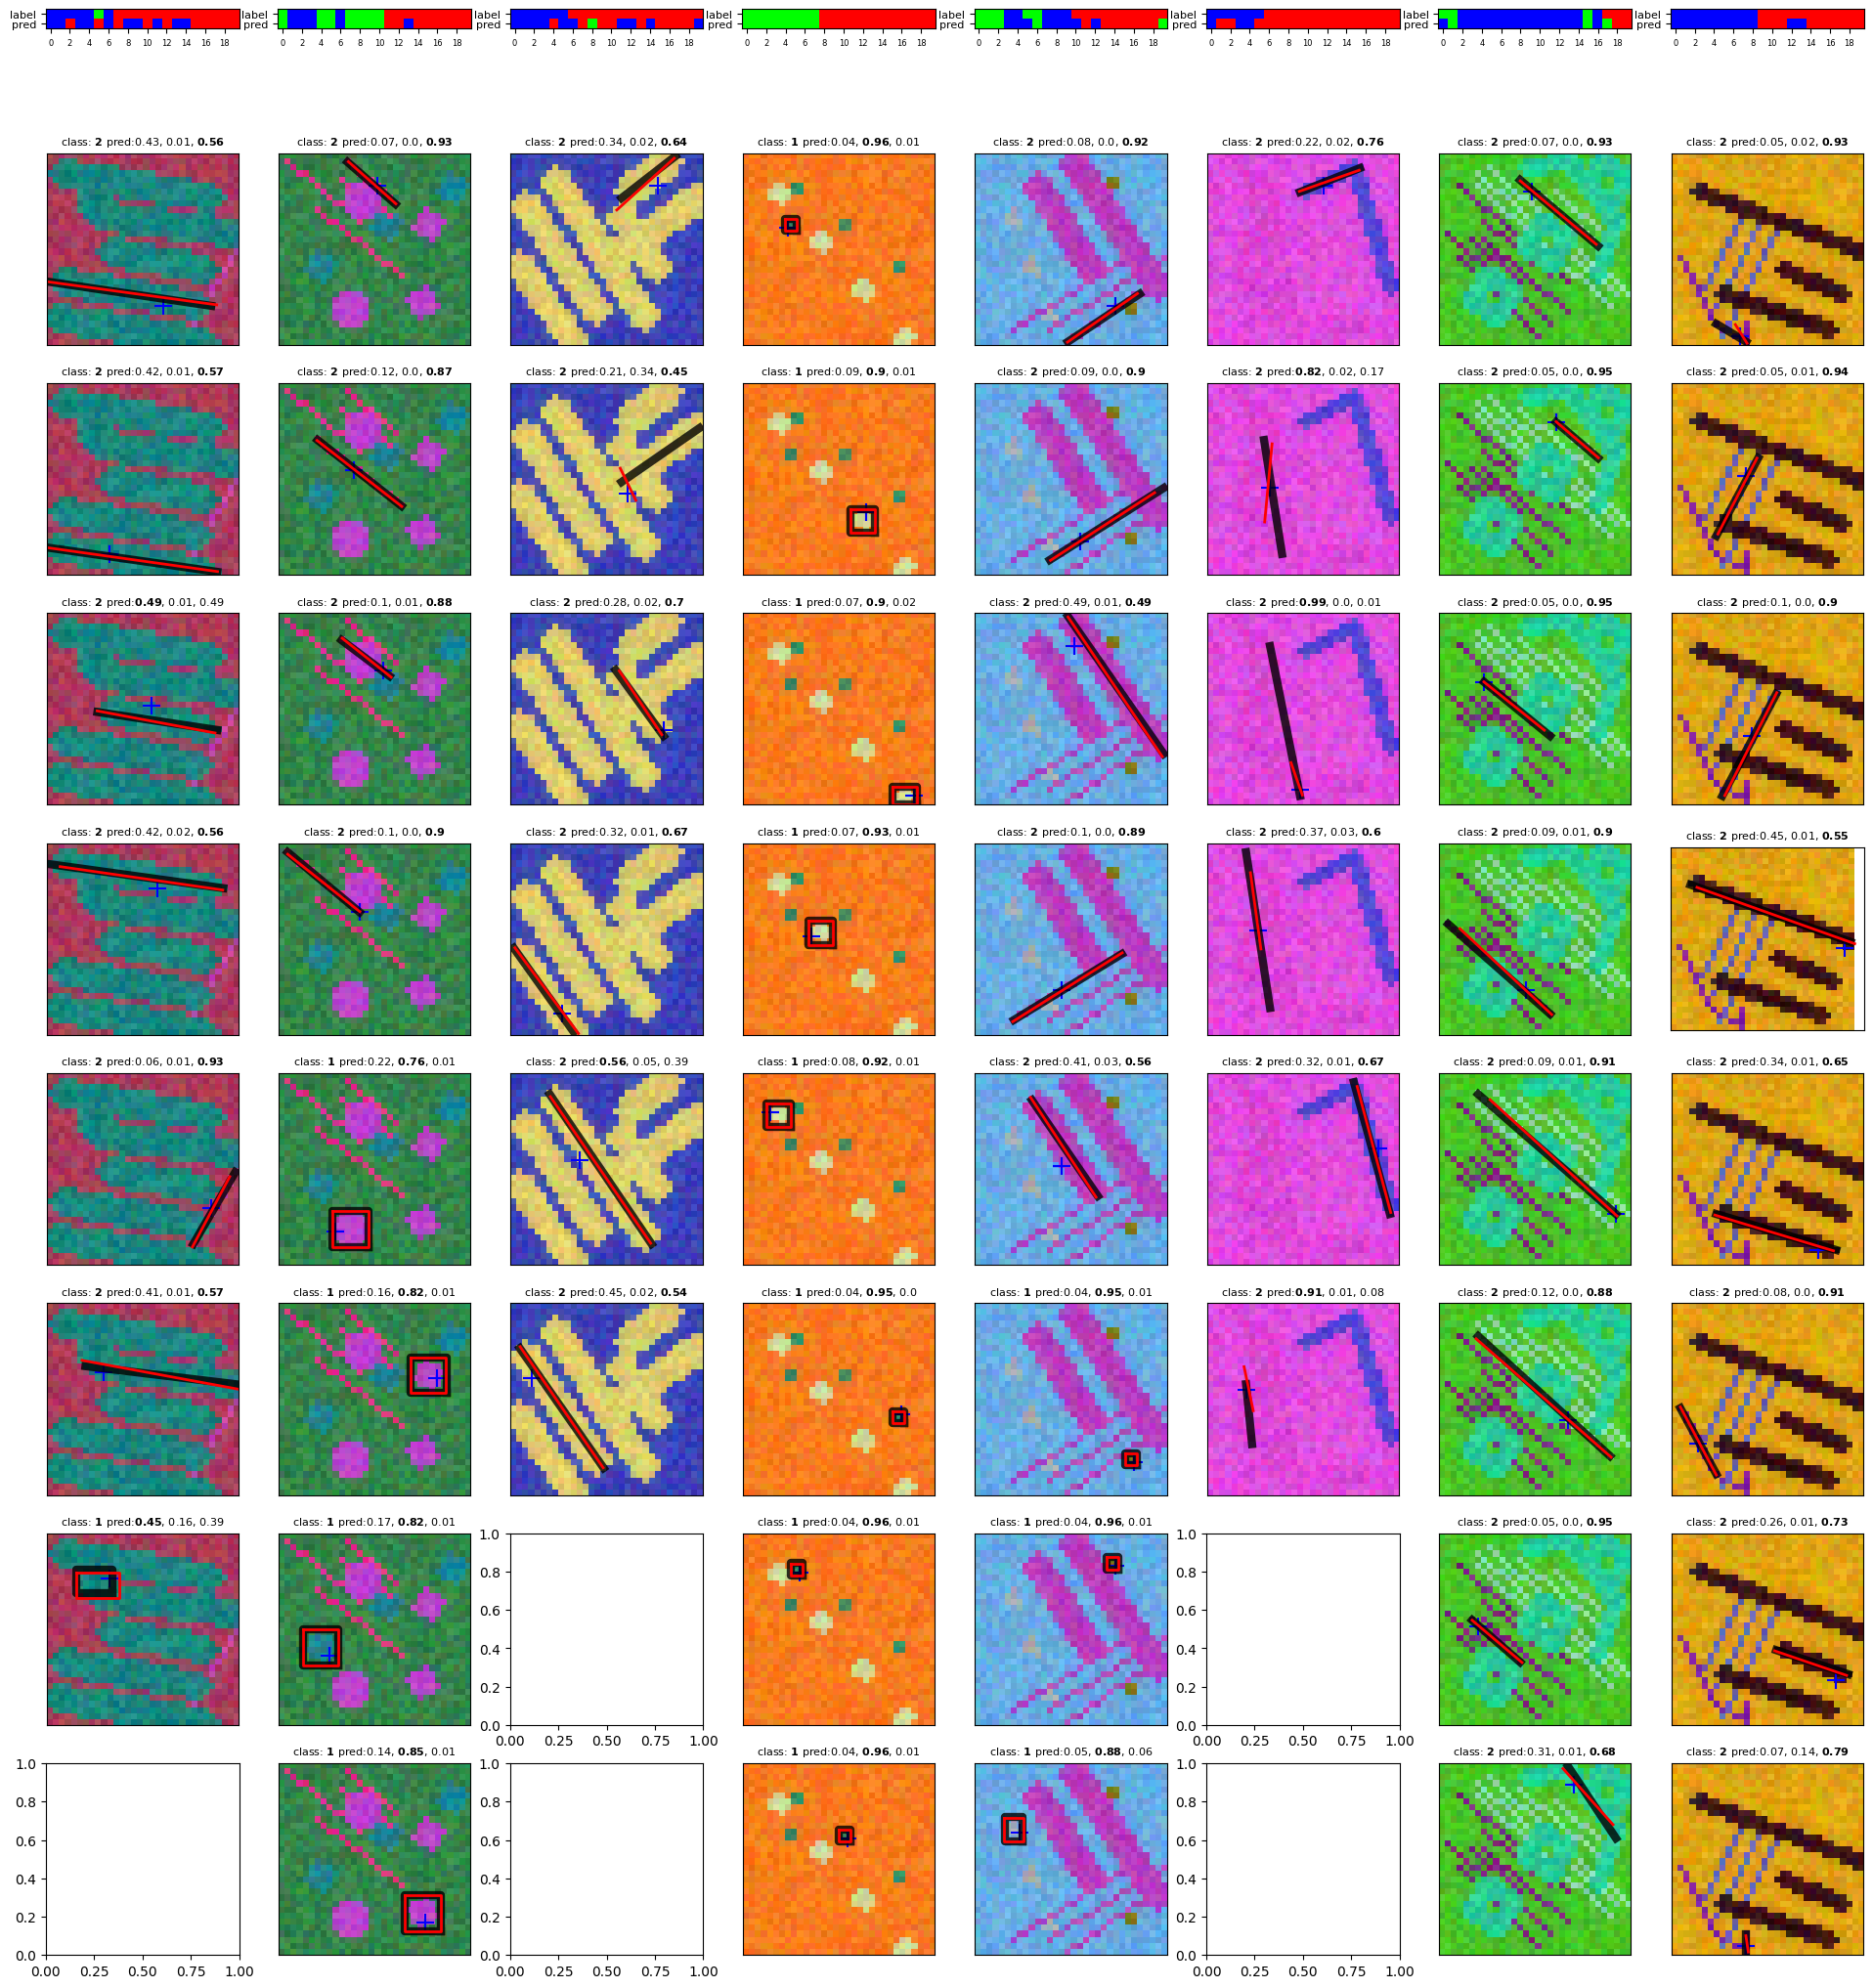

In [39]:
features, labels, labels_weights = next(test_iter)
img, sample_points, class_split = features.values()
vecs_labels, components_class = labels.values()
vecs_weights, class_weights = tf.where(labels_weights['vecs']>0, 1.0, 0.0), labels_weights['class']


print('img', img.shape, img.dtype)
print('sample_points', sample_points.shape, sample_points.dtype)
print('class_split', class_split.shape, class_split.dtype)
print('vec_labels', vecs_labels.shape, vecs_labels.dtype)
print('components_class', components_class.shape, components_class.dtype)
print('vecs_weights', vecs_weights.shape, vecs_weights.dtype)
print('class_weights', class_weights.shape, class_weights.dtype)


vecs_labels =tf.reduce_sum(tf.reshape(vecs_labels, (-1,cfg.sample_points,2,2,2)), axis=-3)

pred_vecs, pred_class = trainer.model(features, training=False).values()

components_class = tf.argmax(components_class, axis=-1)
#pred_class = tf.argmax(pred_class, axis=-1)

print('pred_vecs', pred_vecs.shape, pred_vecs.dtype)
print('pred_class', pred_class.shape, pred_class.dtype)

pred_vecs =tf.reduce_sum(tf.reshape(pred_vecs, (-1,cfg.sample_points,2,2,2)), axis=-3)


label_colors = tf.one_hot(components_class, 3)
pred_colors = tf.one_hot(tf.argmax(pred_class, axis=-1), 3)
stacked_colors = tf.cast(tf.stack([label_colors, pred_colors], axis=-3)*255, tf.int32)

s=8
i=0

max_rows=8
rows = min(max_rows, cfg.sample_points)

print('\n background: RED, bbox: GREEN, line: BLUE \n')

fig, axs = plt.subplots(rows+1, s, figsize=(s*3, (rows+1)*3))

for i in range(s):
    i_vecs, i_bboxes = vcm.prepare_components_vecs_to_plot(vecs_labels[i], components_class[i])
    p_vecs, p_bboxes = vcm.prepare_components_vecs_to_plot(pred_vecs[i], components_class[i])

    i_components = [i_vecs[...,j] for j in range(i_vecs.shape[-1])] + [i_bboxes[...,j] for j in range(i_bboxes.shape[-1])]
    p_components = [p_vecs[...,j] for j in range(p_vecs.shape[-1])] + [p_bboxes[...,j] for j in range(p_bboxes.shape[-1])]
    
    i_sample_points = gather_sorted_components(sample_points[i], components_class[i])

    i_class = gather_sorted_components(components_class[i], components_class[i])
    i_pred_class = gather_sorted_components(pred_class[i], components_class[i])

    axs[0,i].imshow(stacked_colors[i])
    axs[0,i].set_yticks([0,1],['label', 'pred'], fontsize=8)
    axs[0,i].set_xticks(np.arange(0, cfg.sample_points, 2), np.arange(0, cfg.sample_points, 2), fontsize=6)

    for r in range(rows): #range(cfg.sample_points):
        ax = axs[r+1,i]
        #r = r if r%2==0 else r//2+cfg.sample_points//2
        if r<len(i_components):
            ax.set_title(r'class: $\bf{x}$ pred:'.format(x=i_class[r].numpy())+bold_argmax_print(i_pred_class[r].numpy(),2), fontsize=8)
            ax.imshow(img[i])
            ax.scatter(*i_sample_points[r][::-1], marker='+', color='blue', s=150)
            ax.plot(*i_components[r], color='black', linewidth=6, alpha=0.8)
            ax.plot(*p_components[r], color='red', linewidth=2)
            ax.set_xticks([])
            ax.set_yticks([])

# Mid Layers Analysis

## MHA scores map

In [43]:
inter_model = tf.keras.Model(trainer.model.input, (trainer.model.get_layer('vdMHA_2').output[1], trainer.model.output))

/home/fzzyfoxx/.local/lib/python3.10/site-packages/keras/src/models/functional.py:106: UserWarning: When providing `inputs` as a dict, all keys in the dict must match the names of the corresponding tensors. Received key 'img' mapping to value <KerasTensor shape=(None, 32, 32, 3), dtype=float32, sparse=None, name=keras_tensor_571> which has name 'keras_tensor_571'. Change the tensor name to 'img' (via `Input(..., name='img')`)
  warnings.warn(


img (8, 32, 32, 3) <dtype: 'float32'>
sample_points (8, 20, 2) <dtype: 'int32'>
class_split (8, 20) <dtype: 'float32'>
vec_labels (8, 20, 4, 2) <dtype: 'float32'>
components_class (8, 20) <dtype: 'float32'>
vecs_weights (8, 20) <dtype: 'float32'>
class_weights (8, 20) <dtype: 'float32'>
pred_vecs (8, 20, 4, 2) <dtype: 'float32'>
pred_class (8, 20) <dtype: 'float32'>
scores_map (8, 20, 32, 32) <dtype: 'float32'>


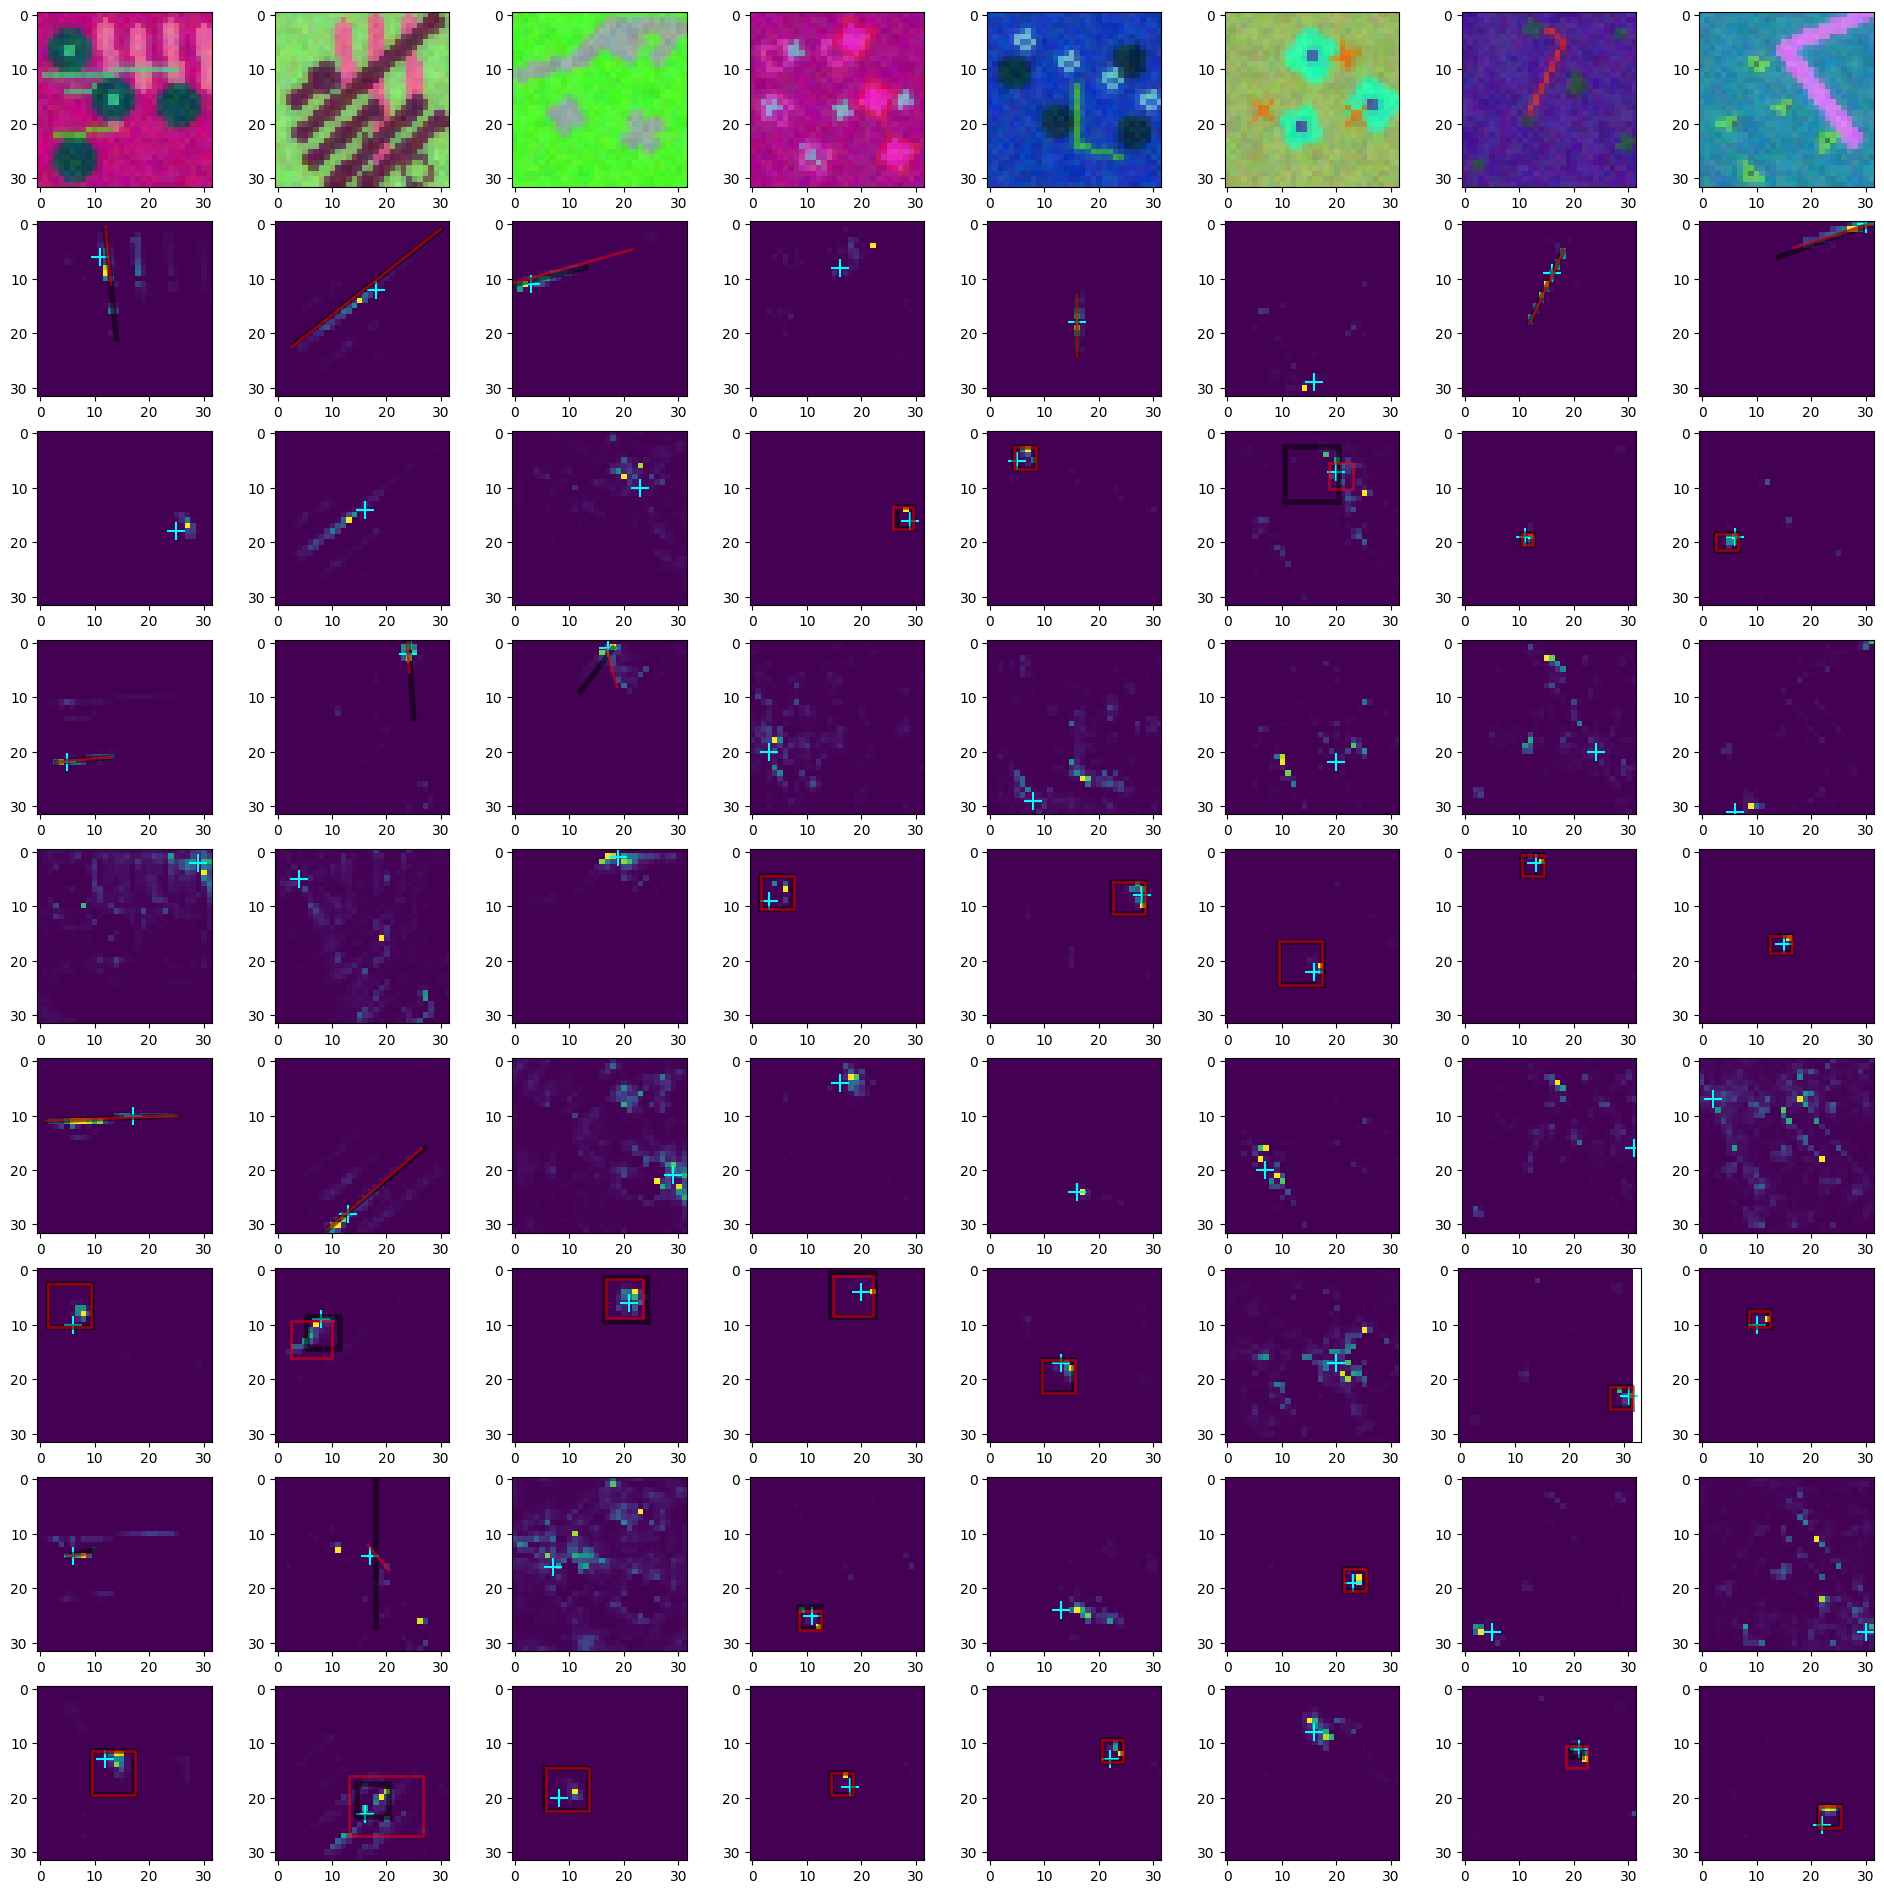

In [44]:
#features, labels, labels_weights = next(test_iter)
img, sample_points, class_split = features.values()
vecs_labels, components_class = labels.values()
vecs_weights, class_weights = [tf.where(o>0, 1.0, 0.0) for o in labels_weights.values()]


print('img', img.shape, img.dtype)
print('sample_points', sample_points.shape, sample_points.dtype)
print('class_split', class_split.shape, class_split.dtype)
print('vec_labels', vecs_labels.shape, vecs_labels.dtype)
print('components_class', components_class.shape, components_class.dtype)
print('vecs_weights', vecs_weights.shape, vecs_weights.dtype)
print('class_weights', class_weights.shape, class_weights.dtype)

vecs_labels =tf.reduce_sum(tf.reshape(vecs_labels, (-1,cfg.sample_points,2,2,2)), axis=-3)



scores_map, preds  = inter_model(features, training=False)
scores_map = tf.reshape(scores_map[:,:,0], (cfg.test_batch_size, cfg.sample_points, generator_cfg.size, generator_cfg.size))
pred_vecs, pred_class = preds.values()

print('pred_vecs', pred_vecs.shape, pred_vecs.dtype)
print('pred_class', pred_class.shape, pred_class.dtype)
print('scores_map', scores_map.shape, scores_map.dtype)
pred_vecs =tf.reduce_sum(tf.reshape(pred_vecs, (-1,cfg.sample_points,2,2,2)), axis=-3)

s=8
i=0

max_rows=8
rows = min(max_rows, cfg.sample_points)

fig, axs = plt.subplots(rows+1, s, figsize=(s*3, rows*3))

for i in range(s):
    i_vecs, i_bboxes = vcm.prepare_components_vecs_to_plot(vecs_labels[i], components_class[i])
    p_vecs, p_bboxes = vcm.prepare_components_vecs_to_plot(pred_vecs[i], components_class[i])

    i_components = [i_vecs[...,j] for j in range(i_vecs.shape[-1])] + [i_bboxes[...,j] for j in range(i_bboxes.shape[-1])]
    p_components = [p_vecs[...,j] for j in range(p_vecs.shape[-1])] + [p_bboxes[...,j] for j in range(p_bboxes.shape[-1])]

    i_sample_points = tf.concat([tf.gather(sample_points[i], tf.where(components_class[i]==1)[...,0], axis=0),
                                 tf.gather(sample_points[i], tf.where(components_class[i]==0)[...,0], axis=0)], axis=0)
    
    i_maps = tf.concat([tf.gather(scores_map[i], tf.where(components_class[i]==1)[...,0], axis=0),
                                 tf.gather(scores_map[i], tf.where(components_class[i]==0)[...,0], axis=0)], axis=0)
    
    i_weights = tf.concat([tf.gather(class_weights[i], tf.where(components_class[i]==1)[...,0], axis=0),
                                 tf.gather(class_weights[i], tf.where(components_class[i]==0)[...,0], axis=0)], axis=0)
    axs[0,i].imshow(img[i])
    for r in range(rows): #range(cfg.sample_points):
        ax = axs[r+1,i]
        r = r if r%2==0 else r//2+cfg.sample_points//2
        ax.imshow(i_maps[r])
        ax.scatter(*i_sample_points[r][::-1], marker='+', color='aqua', s=150)
        if i_weights[r]>0:
            ax.plot(*i_components[r], color='black', linewidth=4, alpha=0.5)
            ax.plot(*p_components[r], color='red', linewidth=2, alpha=0.5)

## Query-Samples

In [36]:
inter_model = tf.keras.Model(trainer.model.input, (trainer.model.get_layer('Query-Sample_2').output, trainer.model.output))

img (8, 32, 32, 3) <dtype: 'float32'>
sample_points (8, 20, 2) <dtype: 'int32'>
class_split (8, 20) <dtype: 'float32'>
vec_labels (8, 20, 4, 2) <dtype: 'float32'>
components_class (8, 20) <dtype: 'float32'>
vecs_weights (8, 20) <dtype: 'float32'>
class_weights (8, 20) <dtype: 'float32'>
pred_vecs (8, 20, 4, 2) <dtype: 'float32'>
pred_class (8, 20) <dtype: 'float32'>
queries_points (8, 20, 8, 2) <dtype: 'float32'>


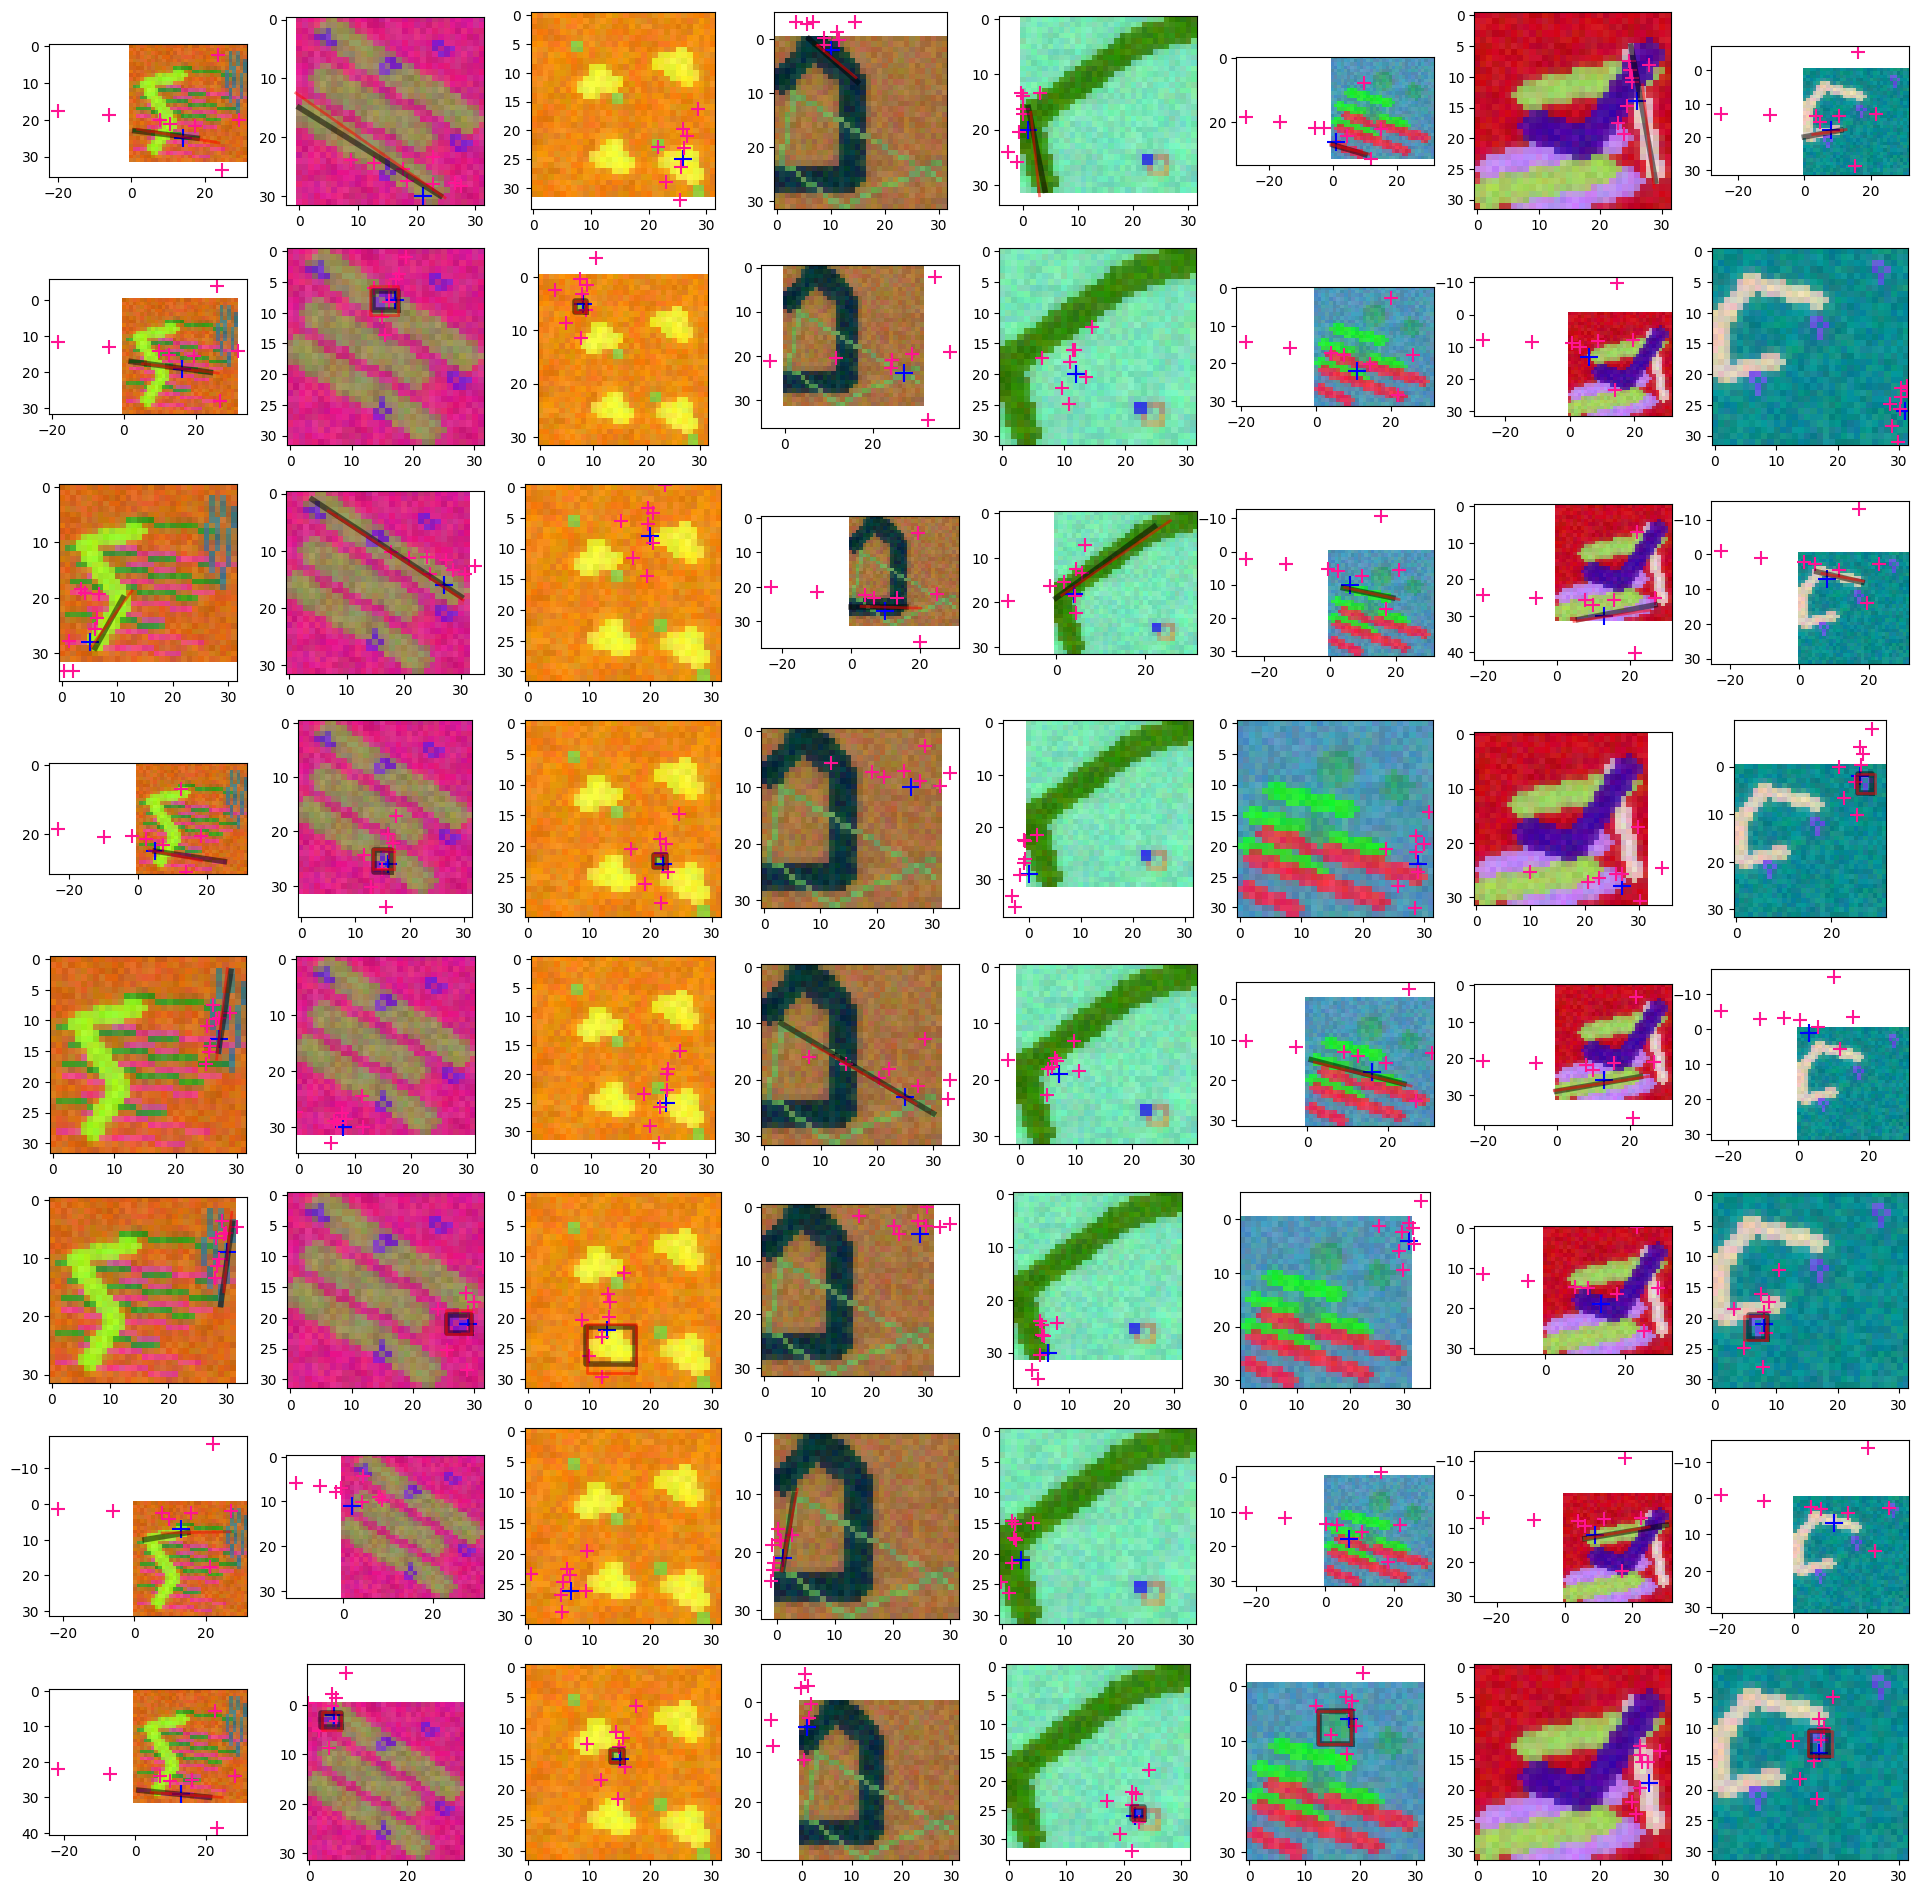

In [37]:
features, labels, labels_weights = next(test_iter)
img, sample_points, class_split = features.values()
vecs_labels, components_class = labels.values()
vecs_weights, class_weights = [tf.where(o>0, 1.0, 0.0) for o in labels_weights.values()]


print('img', img.shape, img.dtype)
print('sample_points', sample_points.shape, sample_points.dtype)
print('class_split', class_split.shape, class_split.dtype)
print('vec_labels', vecs_labels.shape, vecs_labels.dtype)
print('components_class', components_class.shape, components_class.dtype)
print('vecs_weights', vecs_weights.shape, vecs_weights.dtype)
print('class_weights', class_weights.shape, class_weights.dtype)

vecs_labels =tf.reduce_sum(tf.reshape(vecs_labels, (-1,cfg.sample_points,2,2,2)), axis=-3)



queries_points, preds  = inter_model(features, training=False)
pred_vecs, pred_class = preds.values()

print('pred_vecs', pred_vecs.shape, pred_vecs.dtype)
print('pred_class', pred_class.shape, pred_class.dtype)
print('queries_points', queries_points.shape, queries_points.dtype)
pred_vecs =tf.reduce_sum(tf.reshape(pred_vecs, (-1,cfg.sample_points,2,2,2)), axis=-3)

s=8
i=0

max_rows=8
rows = min(max_rows, cfg.sample_points)

fig, axs = plt.subplots(rows, s, figsize=(s*3, rows*3))

for i in range(s):
    i_vecs, i_bboxes = vcm.prepare_components_vecs_to_plot(vecs_labels[i], components_class[i])
    p_vecs, p_bboxes = vcm.prepare_components_vecs_to_plot(pred_vecs[i], components_class[i])

    i_components = [i_vecs[...,j] for j in range(i_vecs.shape[-1])] + [i_bboxes[...,j] for j in range(i_bboxes.shape[-1])]
    p_components = [p_vecs[...,j] for j in range(p_vecs.shape[-1])] + [p_bboxes[...,j] for j in range(p_bboxes.shape[-1])]

    i_sample_points = tf.concat([tf.gather(sample_points[i], tf.where(components_class[i]==1)[...,0], axis=0),
                                 tf.gather(sample_points[i], tf.where(components_class[i]==0)[...,0], axis=0)], axis=0)
    
    i_queries_points = tf.concat([tf.gather(queries_points[i], tf.where(components_class[i]==1)[...,0], axis=0),
                                 tf.gather(queries_points[i], tf.where(components_class[i]==0)[...,0], axis=0)], axis=0)
    
    i_weights = tf.concat([tf.gather(class_weights[i], tf.where(components_class[i]==1)[...,0], axis=0),
                                 tf.gather(class_weights[i], tf.where(components_class[i]==0)[...,0], axis=0)], axis=0)
    for r in range(rows): #range(cfg.sample_points):
        ax = axs[r,i]
        r = r if r%2==0 else r//2+cfg.sample_points//2
        ax.imshow(img[i])
        ax.scatter(*i_sample_points[r][::-1], marker='+', color='blue', s=150)
        ax.scatter(*tf.transpose(i_queries_points[r], [1,0])[::-1], marker='+', color='deeppink', s=100)
        if i_weights[r]>0:
            ax.plot(*i_components[r], color='black', linewidth=4, alpha=0.5)
            ax.plot(*p_components[r], color='red', linewidth=2, alpha=0.5)

# experiments

In [13]:
features = tf.ones((8,1,1024,64))
sample_features = tf.ones((8,20,1,64))
sample_points = tf.ones((8,20,2))
pos_enc = tf.ones((8,20,1024,64))

query_points = tf.ones((8,20,6,2))
unsqueezed_features = tf.ones((8,32,32,64))

shape = tf.shape(query_points)
B, sample_points_num, query_points_num = [shape[i] for i in range(3)]
query_boxes = tf.concat([query_points-0.5, query_points+0.5], axis=-1)
print(query_boxes.shape)
box_indices = tf.reshape(tf.repeat(tf.range(B, dtype=tf.int32)[:,tf.newaxis], sample_points_num*query_points_num, axis=-1), (-1,))
print(box_indices.shape)
query_boxes = tf.reshape(query_boxes, (-1,4))
print(query_boxes.shape)

query_samples = tf.image.crop_and_resize(unsqueezed_features, query_boxes, box_indices, crop_size=[1,1])
print(query_samples.shape)
query_samples = tf.reshape(query_samples, (B, sample_points_num, query_points_num, -1))
print(query_samples.shape)

(8, 20, 6, 4)
(960,)
(960, 4)
(960, 1, 1, 64)
(8, 20, 6, 64)


In [ ]:
query_points = vcm.QuerySamplingLayer(queries_num=6, mid_layers=1, mid_units=64, activation='relu', dropout=0.0)([sample_features, sample_points])
print(query_points.shape)

query_samples = vcm.SampleQueryExtractionLayer(crop_size=[1,1])([features, query_points])
print(query_samples.shape)

a = vcm.SampleQueryMessagePassing(num_heads=1, size=32, mid_layers=1, mid_units=64, activation='relu', dropout=0.0, enc_type='frequency')(sample_features, query_samples, sample_points, query_points)
print(a.shape)

(8, 20, 6, 2)
(8, 20, 6, 64)
(8, 20, 1, 64)


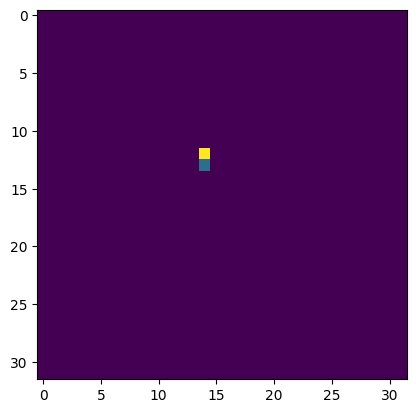

In [ ]:
yx = xy_coords((32,32))[...,::-1]
p = tf.constant([12.4, 14.1], tf.float32)

diffs = tf.reduce_sum(tf.abs(p-yx), axis=-1, keepdims=True)
bilinear_map = tf.nn.relu(1-diffs+1e-4)**2
bilinear_map /= tf.reduce_sum(bilinear_map)+1e-4
plt.imshow(bilinear_map)